<H1>MAT 201A Winter 2016 Final Project</H1>
<H2>Rachel Sowa</H2>

The goal of this project is to explore using linear predictive coding to implement a vocoder-like synthesis algorithm.
Linear predictive coding (LPC) operates under the idea that the human voice can be modeled as an excitation source (i.e. the vocal chords) run through a filter (i.e. the throat and mouth cavity). LPC attempts to predict the value of a sample based on a linear combination of the p previous samples. In this project, I am using p=12. The LPC algorithm chooses an approximation of these p coefficients by finding the coefficients that minimize the mean square error between the original sample and the predicted sample. These coefficients can then be used to construct an FIR filter that models the formants of the signal. Running a constructed excitation source through this filter then recreates a rough version of the original speech signal.

In [34]:
%pylab inline
from audiolazy import * # using the audiolazy python library to compute the lpc coefficients filter,
                        # as well as the autocorrelation function
import scipy.signal as sig
from scipy.io import wavfile
from IPython.display import Audio

In [2]:
# takes an autocorrelation lags vector and finds the first lag peak after the initial lag=0 peak and returns its index
# if no peak is found, it returns -1 to indicate that the signal is noisy rather than periodic
def findFirstPeak(vector):
    N = len(vector) - 1
    i = 1
    while i < N:
        if (vector[i] > 0.0) and (vector[i] > vector[i - 1]) and (vector[i] > vector[i + 1]):
            return i
        i += 1
    return -1

In [3]:
# simple pitch detection algorithm that uses autocorrelation on a clipped frame to determine if signal is voiced
# or unvoiced, and if it is voiced, it approximates the fundamental frequency of the frame using the first peak lag
# if the signal is unvoiced, it returns -1 instead of a frequency
def pitchDetection(frame,sr):
    frame_N = frame.shape[0]
    clip = frame.max() * 0.3 # clipping threshold
    clippedFrame = np.empty(frame_N)
    n = 0
    while n < frame_N:
        # if value of sample is more than threshold then make it 1
        if frame[n] > clip:
            clippedFrame[n]= 1
        # if value of sample is less than negative of threshold then make it -1
        elif frame[n] < -1.0*clip:
            clippedFrame[n] = -1
        # if value of sample is in between positive and negative thresholds then make it 0
        else:
            clippedFrame[n] = 0
        n += 1
    # perform autocorrelation of clipped frame
    acr = acorr(clippedFrame, max_lag=525) # set the max_lag to be around the frequency limit of the human voice
    # find fundamental frequency
    peak_index = findFirstPeak(acr)
    # if a peak frequency was found
    if peak_index != -1:
        peak = acr[peak_index]
        # if energy of first lag is high enough then it is voiced
        if peak >= acr[0]*0.3:
            return sr / peak
        # if energy is low, it is more likely to be unvoiced
        else:
            return -1
    # no peak frequency found, so it is unvoiced
    else:
        return -1

In [4]:
# returns an impulse stream with one pulse every pitch period
def makePulse(freq,sample_rate,frame_size):
    period = int(sample_rate / freq)
    i = 0
    pls = np.zeros(frame_size)
    while i < frame_size:
        if i % period == 0:
            pls[i] = 1.0
        else:
            # adding a tiny bit of random noise to the stream to help it sound more natural
            pls[i] = (np.random.rand() - 0.5)*0.1 
        i += 1
    return pls

In [5]:
# performs LPC and pitch detection on an input signal,
# and uses the results to resynthesize the signal with a vocoder effect
def lpcResynth(signal, window, samp_rate):
    # defining length of window
    win_N = window.shape[0]
    # defining length of input signal
    signal_N = signal.shape[0]
    # definning overlap factor
    overlap = 0.5
    # defining hop size
    hop_N = int(floor(win_N * (1.0 - overlap))) # ignoring last frame so that the math works out nicely
    
    reconstructed = numpy.zeros(signal_N)

    start = 0
    end = signal_N - win_N
    # loop through each frame
    while start < end:
        
        # extract frame
        frame = signal[start:start + win_N] * window
        
        # perform lpc algorithm on frame, which returns a filter constructed with the lpc coefficients
        analysis_filt = lpc.covar(frame, 12)
        # synthesis filter is the inverse of the analysis filter
        synth_filt = 1 / analysis_filt
        
        # determine fundamental pitch of the frame
        pitch = pitchDetection(frame,samp_rate)
        # create an excitation source to put throught the synthesis filter
        excitation = empty(0)
        gain = sqrt(analysis_filt.error)
        # if frame is unvoiced use white noise to represent fricative sounds
        if pitch == -1:
            excitation = array(white_noise().take(win_N))*gain
        # if frame is voiced use a signal with a pulse every pitch period to represent vocal chords
        else:
            excitation = makePulse(pitch,samp_rate,win_N)
        
        # pass the excitation source through the resynthesis filter
        resynth = array(synth_filt(excitation).take(win_N))
        
        # and add this to the overall resynthesized signal, being careful to account for overlap
        reconstructed[start:start + win_N] += array(resynth)
        start += hop_N
    # return resynthesized signal
    return reconstructed

Let's try the algorithm out on a recording of two people talking. I'll use one from a previous lecture in class.

In [6]:
rate, talking = wavfile.read("../../sources/passport.wav")
talking = talking / 2.**15

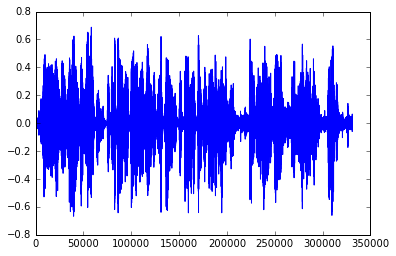

In [7]:
plot(talking)

In [36]:
Audio(talking, rate=rate)

In [9]:
s, Hz = sHz(rate) # Seconds and hertz
ms = 1e-3 * s
frameSize = 30 * ms # generally 20 to 30 ms is a good frame size for recognizable LPC synthesis

In [10]:
talking_synth = lpcResynth(talking, sig.hann(frameSize), rate)

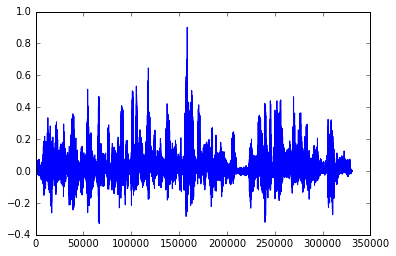

In [20]:
plot(talking_synth/50.)

In [37]:
Audio(talking_synth/50., rate=rate)

Okay, it sounds pretty alien, but if you listen closely you can here some recognizable words.

What happens if we try the algorithm on a recording of someone singing?

In [16]:
rate, adele = wavfile.read("./adele1.wav")
adele = adele / 2.**15
adele = adele[:,0] # converting from stereo to mono

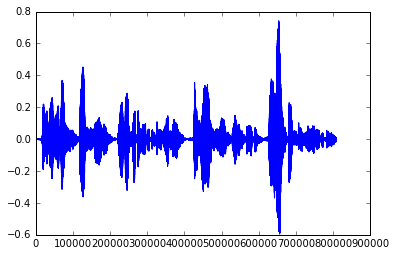

In [17]:
plot(adele)

In [38]:
Audio(adele, rate=rate)

In [19]:
adele_synth = lpcResynth(adele, sig.hann(frameSize), rate)

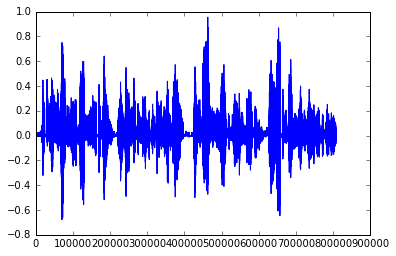

In [22]:
plot(adele_synth/350.)

In [39]:
Audio(adele_synth/350., rate=rate)

Woah, what?! That sounds even less like the original recording than the previous example. What's going on?

It turns out that my autocorrelation pitch detection method is pretty rudimentary. It doesn't do anything to account for rapid bursts of unvoiced speech sandwiched in the middle of voiced speech, or for rapid fluctuations/outliers in pitch of voiced speech. More sophisticated pitch detection algorithms implement many techniques to attempt to smooth and/or average the pitch values over the entire signal or to use neighboring frames' pitches to help determine the current pitch. This helps to get rid of rapid blips in the resynthesized signal that throw the human ear off when trying to detect speech patterns.

However, the current algorithm is already pretty computationally expensive, which means that it's reeeeeeeeally slow in Python (it took about 5 minutes to compute the adele_synth). So an even more complex algorithm isn't practical on this platform.

In addition to attempting to create a vocoder-like algorithm, I also played around with trying to create a whisper effect, such as that used in Paul Lansky's piece <i>Six Fantasies on a Poem by Thomas Campion.</i>

The whisper algorithm is identical to the above synthesis algorithm, except that instead of detecting whether a frame is voiced or unvoiced, it just assumes that it is unvoiced and uses white noise as an excitation source for every frame.

In [24]:
def whisper(signal, window, samp_rate):
    # defining length of window
    win_N = window.shape[0]
    # defining length of input signal
    signal_N = signal.shape[0]
    # definning overlap factor
    overlap = 0.5
    #defining hop size
    hop_N = int(floor(win_N * (1.0 - overlap))) #ignoring last frame so that the math works out nicely
    
    reconstructed = numpy.zeros(signal_N)

    start = 0
    end = signal_N - win_N
    #loop through each frame
    while start < end:
        
        # extract frame
        frame = signal[start:start + win_N] * window
        
        # perform lpc algorithm on frame, which returns a filter constructed with the lpc coefficients
        analysis_filt = lpc.covar(frame, 12)
        # synthesis filter is the inverse of the analysis filter
        synth_filt = 1 / analysis_filt
        
        gain = sqrt(analysis_filt.error)
        # only use white noise to create excitation source
        excitation = array(white_noise().take(win_N))*gain

        # pass the excitation source through the resynthesis filter
        resynth = array(synth_filt(excitation).take(win_N))
        
        # and add this to the overall resynthesized signal, being careful to account for overlap
        reconstructed[start:start + win_N] += array(resynth)
        start += hop_N
    # return resynthesized signal
    return reconstructed

In [25]:
talking_whisper = whisper(talking, sig.hann(frameSize), rate)

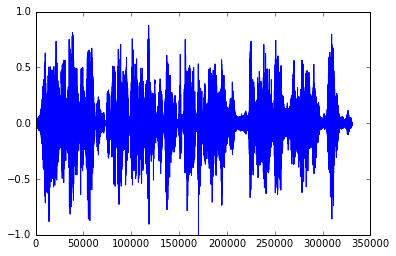

In [28]:
plot(talking_whisper/15.5)

In [40]:
Audio(talking_whisper/15.5, rate=rate)

In [30]:
adele_whisper = whisper(adele, sig.hann(frameSize), rate)

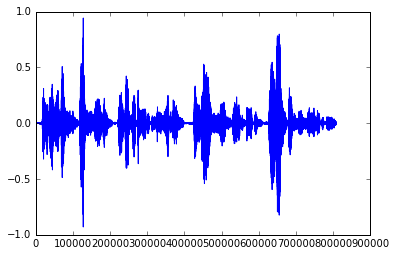

In [32]:
plot(adele_whisper/17.)

In [41]:
Audio(adele_whisper/17., rate=rate)